In [1]:
# http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
from __future__ import unicode_literals, print_function, division
from io import open
import glob
from torch.autograd import Variable
tri_FLAG = True

In [2]:
def findFiles(path): return glob.glob(path)

# print(findFiles('data/names/*.txt'))
# print(findFiles('train/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = [] # yezheng: this is a global variable
# Read a file and split into lines
def readLines(filename):
    try: # yezheng -- tackle with "ISO-8859-1"
        fd = open(filename, encoding='utf-8', errors='ignore')
    except:
        fd = open(filename, encoding="ISO-8859-1")
    lines = fd.read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
    fd.close()

# for filename in findFiles('data/names/*.txt'):
num_tot_train = 0
for filename in findFiles('train/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    num_tot_train += len(lines)
    category_lines[category] = lines
    print(filename,len(lines))
n_categories = len(all_categories)

category_lines_val = {}
global num_tot_val
num_tot_val = 0
for filename in findFiles('val/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines_val[category] = lines
    num_tot_val += len(lines)


train/in.txt 3000
train/pk.txt 3000
train/fr.txt 3000
train/af.txt 3000
train/cn.txt 3000
train/za.txt 3000
train/fi.txt 3000
train/ir.txt 3000
train/de.txt 3000


In [3]:
print(f"n_categories={n_categories} n_letters{n_letters}")

n_categories=9 n_letters57


In [4]:
# print(category_lines['Italian'][:5])
print(category_lines['cn'][:5])
print(all_letters)
print(all_categories)

['yungming', 'xingzhuang', 'liren', 'hongjiaotian', 'guanrenling']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de']


In [5]:
import torch
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter): return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line): 
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
#yezheng: from HW5: evaluating trigram
from collections import *
from random import random
import numpy as np
def train_char_lm(fname, order=2, add_k=1):
  ''' Trains a language model.
  This code was borrowed from http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139
  Inputs:
    fname: Path to a text corpus.
    order: The length of the n-grams.
    add_k: k value for add-k smoothing. NOT YET IMPLMENTED

  Returns:
    A dictionary mapping from n-grams of length n to a list of tuples.
    Each tuple consists of a possible net character and its probability.
  '''
  # TODO: Add your implementation of add-k smoothing.
  #   data = open(fname).read()
#-------------
  lm = defaultdict(Counter)
  fnameLst = fname
  if isinstance(fname, str): fnameLst = [fname]
  lm = defaultdict(Counter)
#   print(fnameLst)
  for fnm in fnameLst:
      try: # yezheng -- tackle with "ISO-8859-1"
            fd = open(fnm, encoding='utf-8', errors='ignore')
      except:
            fd = open(fnm, encoding="ISO-8859-1")
      AllChars = set()
      for data in fd.readlines():
          data = data.lower()
          AllChars.update(data)
          pad = "~" * order # yezheng: this is just setting beginning of a line -- just like <s><s> mentioned in chapter 4
          data = pad + data
          for i in range(len(data)-order):
            history, char = data[i:i+order], data[i+order]
            lm[history][char]+=1
          del history
          del char
          del i
      for his in lm.keys():
        for ch in AllChars: lm[his][ch]+=0 
      fd.close()
#-------------
  def normalize(counter): # input is a dictionary
    s = float(sum(counter.values())) + add_k *len(counter)
    return [(c,(cnt+add_k)/s) for c,cnt in counter.items()]
  outlm = {hist:normalize(chars) for hist, chars in lm.items()}
  return outlm

# def perplexity_yezheng_string(cityname, lm, order=2):
#   '''Computes the perplexity of a text file given the language model.
#   Inputs:
#     test_filename: path to text file
#     lms: The output from calling train_char_lms.
#     order: The length of the n-grams in the language model. #yezheng: order can be read from lm?
#   Outputs:
#     max_labels: a list of predicted labels
#   '''
#   #order = len(list(lm.keys())[0]) #yezheng: I think it should not be an argument
#   pad = "~" * order
#   data = pad + cityname
#   data = data.lower()
#   # TODO: YOUR CODE HERE
#   # Daphne: make sure (num of characters > order)
#   logPP = 0
#   for i in range(len(data)-order):
#     history, char = data[i:(i+order)], data[i+order]   
#     if history not in lm:
#       logPP += np.log2(8.0/len(lm)) # float("-inf") # yezheng: deal with unknowns
#     else:
#       dict_temp = dict(lm[history])
#       if char not in dict_temp:
#         logPP += np.log2(8.0/len(lm)) #float("-inf")  # yezheng: deal with unknowns
#       else: logPP += np.log2(dict_temp[char])
#   return logPP/len(data) #yezheng: we forget to divide this by len(data) in HW5

import os
lms_dict_tri = {}# a dictionary of lms
for filename in os.listdir('train'):
    filepath = ['train/' + filename,'val/' + filename]
    lms_dict_tri[filename[:2]] = train_char_lm(filepath)  #, order=order, add_k = AddK

def trigramTensor(line, lms_dict, order=2): # n_label*n_letters
    tensor = torch.zeros(len(line), 1, n_categories*n_letters)
    data = "~" *order + line
    input_feature = []
    for li in range(len(data)-order):
        for idx_lm,lm_name in enumerate(lms_dict.keys()):
            history, ch = data[li:(li+order)], data[li+order]   
            lm = lms_dict[lm_name]
            if history not in lm:
              for j in range(n_letters): 
#                 print("tensor[li][0][idx_lm*n_letters + j]",tensor[li][0][idx_lm*n_letters + j])
                tensor[li][0][idx_lm*n_letters + j] =np.log2(8.0/len(lm)) 
            else:
              dict_temp = dict(lm[history])
              if ch not in dict_temp:
                tensor[li][0][idx_lm*n_letters + letterToIndex(ch) ]= np.log2(8.0/len(lm)) #float("-inf")  # yezheng: deal with unknowns
              else:  
                tensor[li][0][idx_lm*n_letters + letterToIndex(ch) ] = np.log2(dict_temp[ch])
    return tensor

# def lineToTensor(line):
#     tensor = torch.zeros(len(line), 1, n_letters)
#     for li, letter in enumerate(line): 
#         tensor[li][0][letterToIndex(letter)] = 1
#     return tensor

n_hidden = 60
if tri_FLAG:
    print(trigramTensor('J',lms_dict_tri).size())
    print(trigramTensor('Jones',lms_dict_tri).size())
else:
    print(letterToTensor('J'))
    print(lineToTensor('Jones').size())

torch.Size([1, 1, 513])
torch.Size([5, 1, 513])


In [7]:
# I have not used this one
import torch.nn as nn
import torch.optim as optim 

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size # yezheng
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2h = nn.Tanh()
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Dropout()#nn.Tanh()# Dropout is harmful
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
#         if tri_FLAG: print("tri debug", input.size(),hidden.size())
        combined = torch.cat((input, hidden), 1)
        h1 = self.i2h(combined)
        hidden = h1#self.h2h(h1)# yezheng
        o1 = self.i2o(combined)
        output = o1#self.o2o(o1)#yezheng
        if tri_FLAG:
#             output = tchdiv(self.softmax(output),self.input_size) # yezheng: should be divided by input_size
            output = self.softmax(output) 
        else:
            output = self.softmax(output) 
        #yezheng: self.softmax: transforming into "probability"
        return output, hidden

    def initHidden(self): return Variable(torch.zeros(1, self.hidden_size))
    
import torch.nn.functional as F   # 神经网络模块中的常用功能 
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
#         self.word_embeddings = nn.Linear(input_size,)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout = 1) # yezheng: dropout to avoid overfitting
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        return (Variable(torch.zeros(1, 1, self.hidden_dim)),Variable(torch.zeros(1, 1, self.hidden_dim)))
 
    def forward(self, input_embedding): #input_embedding
        embeds = input_embedding #yezheng
#         lstm_out, self.hidden = self.lstm(   embeds.view(len(sentence), 1, -1), self.hidden)
        lstm_out, self.hidden = self.lstm(   embeds.view(len(input_embedding), 1, -1), self.hidden) #yezheng
        h,c= self.hidden # parameters for the last hidden state
#         print("h",h.size())
#         tag_space = self.hidden2tag(lstm_out.view(len(input_embedding), -1)) #yezheng
        tag_space = self.hidden2tag(h) #yezheng 
        tag_scores = tag_space
#         tag_scores = self.log_softmax(tag_space) #tag_space  -- softmax is important
#         print("tag_scores",tag_scores.size())
#         output = tag_scores[-1].view(1,-1)
        output = tag_scores.view(1,-1)
        return output # I just return tag_scores

In [8]:
rnn = RNN(n_letters *n_categories, n_hidden, n_categories)  # yezheng: trigramTensor
n_layers  = 1
# lstm = nn.LSTM(input_size = n_letters *n_categories,hidden_size = n_categories, num_layers = n_layers)
lstm = LSTMTagger(embedding_dim = n_letters *n_categories, hidden_dim = n_hidden, tagset_size = n_categories)

In [9]:
if tri_FLAG:
    input = Variable(trigramTensor('A',lms_dict_tri))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden)
else:
    input = Variable(letterToTensor('A'))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input, hidden)

In [10]:
if tri_FLAG:
    input = Variable(trigramTensor('Albert',lms_dict_tri))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden) # yezheng: strange: I though output should have size related with n_labels
    print(output)
else:
    input = Variable(lineToTensor('Albert'))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden) # yezheng: strange: I though output should have size related with n_labels
    print(output)

Variable containing:
-2.9844 -1.3168 -2.4678 -1.9206 -2.7821 -2.2635 -1.7281 -2.8399 -3.0322
[torch.FloatTensor of size 1x9]



In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

('pk', 1)


In [12]:
import random
def randomChoice(l): return l[random.randint(0, len(l) - 1)]
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    if tri_FLAG: line_tensor = Variable(trigramTensor(line,lms_dict_tri)) # yezheng 
    else: line_tensor = Variable(lineToTensor(line)) 
    return category, line, category_tensor, line_tensor
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = in / line = daru ka nagla
category = fi / line = tvara
category = ir / line = patkestan
category = in / line = khokhri
category = fi / line = zafirovo
category = fi / line = filgueira
category = de / line = nizhniy studenyy
category = in / line = pondok atas afdeling 
category = cn / line = xiaoju
category = cn / line = datanhe


In [13]:
criterion = nn.NLLLoss() #Negative Log Likelihood

In [14]:
def evaluate(line_tensor):
#     hidden = lstm.initHidden()
#     for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)
    return output



def predict(input_line, n_predictions=1):
#     print('\n> %s' % input_line)   
    output = evaluate(Variable(trigramTensor(input_line,lms_dict_tri)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
#         print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
    return all_categories[category_index]

import csv
del category
def Curr_Err_Rate_dev(): 
    global num_tot_val
    num_err = 0
    for catname in all_categories:
        num_err += sum([not catname == predict(cityname) for cityname in category_lines_val[catname]])
    return num_err*1.0/num_tot_val
    
    

In [15]:
# If you set this too high, it might explode. If too low, it might not learn
learning_rate = 0.001#0.004 #0.02 -- blow up (or overfitting)
# 0.0001
optimizer = optim.SGD(lstm.parameters(), lr=learning_rate)

In [16]:
import time
import math

n_iters = 100000 # there are 3000 lines for each of 9 documents
# n_iters_doc = 3
print_every = 5000
plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()
num_err = 0
pre_err_rate = 1


T1 = time.time()

In [17]:
# print("num_tot_val",num_tot_val)
T2 = time.time()
for iter in range(1,n_iters+1): # 我们要训练300次，可以根据任务量的大小酌情修改次数。
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # 清除网络先前的梯度值，梯度值是Pytorch的变量才有的数据，Pytorch张量没有
    lstm.zero_grad()
    # 重新初始化隐藏层数据，避免受之前运行代码的干扰
    lstm.hidden = lstm.init_hidden()
    output_real= lstm(line_tensor)
    
    # 计算损失，反向传递梯度及更新模型参数
#--------

#     output_real = tag_scores[-1].view(1,-1)
    loss = criterion(output_real,category_tensor)
                    
    loss.backward()
#     curr_err_rate = Curr_Err_Rate_dev()#num_err*1.0/iter
#     learning_rate_ad = learning_rate * np.sqrt(max(pre_err_rate - curr_err_rate,0))*5
#     for p in lstm.parameters():   p.data.add_(-learning_rate_ad, p.grad.data)
#     optimizer.step()
    guess, guess_i = categoryFromOutput(output_real) #yezheng: what is 'guess_i' -- the index while 'guess' is the name
#         print("guess",guess)
#     if guess != category: num_err +=1 # this is not important at all
    if iter % print_every == 0:
#         print("h",h.size(),type(h)) 
#         print("output_real",output_real.size(),type(output_real)) 
#         print("len current word:",len(line_tensor))
#         print("tag_scores",tag_scores.size(),type(tag_scores))
        correct = '✓' if guess == category else '✗ (%s)' % category
        curr_err_rate = Curr_Err_Rate_dev()#num_err*1.0/iter
        pre_err_rate = curr_err_rate
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), pre_err_rate, line, guess, correct))

5000 5% (0m 41s) 0.8867 moussonvilliers / fi ✗ (fr)
10000 10% (1m 19s) 0.8867 najafiyeh / af ✗ (fi)
15000 15% (1m 55s) 0.8867 hasan dheri / za ✗ (pk)
20000 20% (2m 29s) 0.8867 ahmad bari / za ✗ (pk)
25000 25% (3m 4s) 0.8867 angadpur / in ✓
30000 30% (3m 39s) 0.8867 aul kazaty / cn ✗ (za)
35000 35% (4m 11s) 0.8867 saintmauricederumilly / fi ✗ (in)
40000 40% (4m 49s) 0.8867 argentolle / za ✗ (fr)
45000 45% (5m 23s) 0.8867 qingta / za ✗ (in)
50000 50% (5m 53s) 0.8867 varnashkino / cn ✗ (in)
55000 55% (6m 25s) 0.8867 komingcheng / de ✗ (cn)
60000 60% (6m 55s) 0.8867 delta city / cn ✗ (de)
65000 65% (7m 34s) 0.8867 ginina matamba / pk ✗ (in)
70000 70% (8m 20s) 0.8867 agadir n' ait sa / za ✗ (ir)
75000 75% (9m 0s) 0.8867 kuusikunnas / fi ✓
80000 80% (9m 34s) 0.8867 kanapera / za ✗ (fi)
85000 85% (10m 9s) 0.8867 irkliyev / za ✗ (ir)
90000 90% (10m 40s) 0.8867 ershiyizong / in ✗ (cn)
95000 95% (11m 13s) 0.8867 deangelis / fi ✗ (de)
100000 100% (11m 47s) 0.8867 nodendorf / cn ✗ (de)


In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

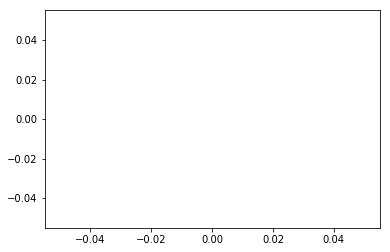

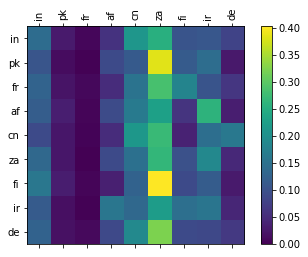

27.024463891983032


In [19]:
T3 = time.time()
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
#     hidden = lstm.initHidden()
#     for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print(time.time() - T3)

In [20]:

# def predict(input_line, n_predictions=1):
# #     print('\n> %s' % input_line)   
#     output = evaluate(Variable(trigramTensor(input_line,lms_dict_tri)))

#     # Get top N categories
#     topv, topi = output.data.topk(n_predictions, 1, True)
#     predictions = []

#     for i in range(n_predictions):
#         value = topv[0][i]
#         category_index = topi[0][i]
# #         print('(%.2f) %s' % (value, all_categories[category_index]))
#         predictions.append([value, all_categories[category_index]])
#     return all_categories[category_index]


# import csv

words_test = []
with open ("cities_test.txt","r",encoding="ISO-8859-1") as f:
    reader = csv.reader(f)
    for row in reader:
        words_test.append(row[0])
        
pred_labels = []
for word in words_test:
    pred_labels.append(predict(word))
    
output_file = open("../labels.txt","w")
for item in pred_labels:
    output_file.write("%s\n" % item)
    
output_file.close()

In [21]:
sum([False,True, False])

1